**Setting up the project path and imports required libraries and ensuring the src folder is accessible so that utility modules can be used in later cells.**

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize

**Setting up the base model (facebook/bart-base) and definining maximum input and target lengths used for preprocessing and tokenization.**

In [3]:
model_name = "facebook/bart-base"
max_input_len = 1024
max_target_len = 256

print("Loading online dataset and preprocessing...")

# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_split = dataset['train']
val_split = dataset['validation']
test_split = dataset['test']

# Concatenate and shuffle
combined_dataset = concatenate_datasets([train_split, val_split, test_split])
combined_dataset = combined_dataset.shuffle(seed=42)

# Fixed-size split
total_size = 10000
train_size = 7000
val_size = 1500
test_size = 1500

train_dataset = combined_dataset.select(range(train_size))
val_dataset = combined_dataset.select(range(train_size, train_size + val_size))
test_dataset = combined_dataset.select(range(train_size + val_size, train_size + val_size + test_size))

print(f"Dataset sizes – Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Loading online dataset and preprocessing...
Dataset sizes – Train: 7000, Val: 1500, Test: 1500


**Loading the BART tokenizer from Hugging Face, which is responsible for converting raw text into token IDs that the model can understand.**

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"], max_length=max_input_len, padding="max_length", truncation=True
    )
    labels = tokenizer(
        examples["highlights"], max_length=max_target_len, padding="max_length", truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["article", "highlights", "id"])
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=["article", "highlights", "id"])
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["article", "highlights", "id"])

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

**Concatenating the train, validation, and test splits from the preprocessed dataset stored on disk to enable unified analysis.**

In [7]:
raw_dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])
sampled_dataset = raw_dataset.shuffle(seed=42).select(range(1000))

article_word_counts = [len(word_tokenize(x["article"])) for x in sampled_dataset]
summary_word_counts = [len(word_tokenize(x["highlights"])) for x in sampled_dataset]

print(f"\nAverage Article Length (words): {np.mean(article_word_counts):.2f}")
print(f"Average Summary Length (words): {np.mean(summary_word_counts):.2f}")



Average Article Length (words): 797.57
Average Summary Length (words): 54.66


**Creating a side-by-side histogram of input and summary lengths to analyze token distribution and ensure appropriate max lengths are chosen for training.**

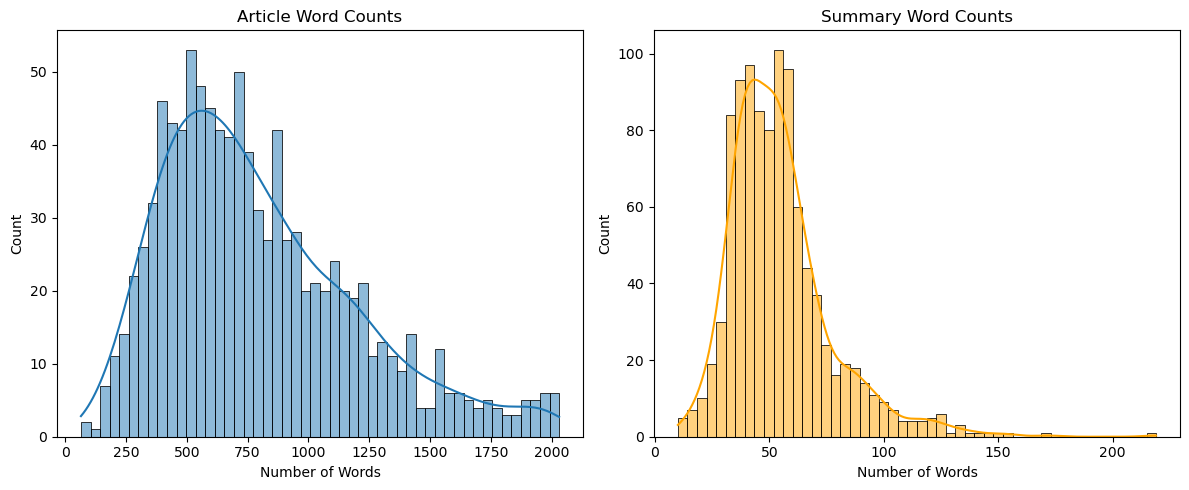

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(article_word_counts, bins=50, kde=True)
plt.title("Article Word Counts")
plt.xlabel("Number of Words")

plt.subplot(1, 2, 2)
sns.histplot(summary_word_counts, bins=50, kde=True, color="orange")
plt.title("Summary Word Counts")
plt.xlabel("Number of Words")

plt.tight_layout()
plt.show()

**Calculating and printing the average number of sentences in articles and summaries from the sampled dataset using NLTK's sent_tokenize**

In [11]:
article_sent_counts = [len(sent_tokenize(x["article"])) for x in sampled_dataset]
summary_sent_counts = [len(sent_tokenize(x["highlights"])) for x in sampled_dataset]

print(f"\nAverage Article Length (sentences): {np.mean(article_sent_counts):.2f}")
print(f"Average Summary Length (sentences): {np.mean(summary_sent_counts):.2f}")


Average Article Length (sentences): 39.13
Average Summary Length (sentences): 3.68


**Plotting histograms for the number of sentences in articles and summaries to visualize sentence distribution and identify summary conciseness.**

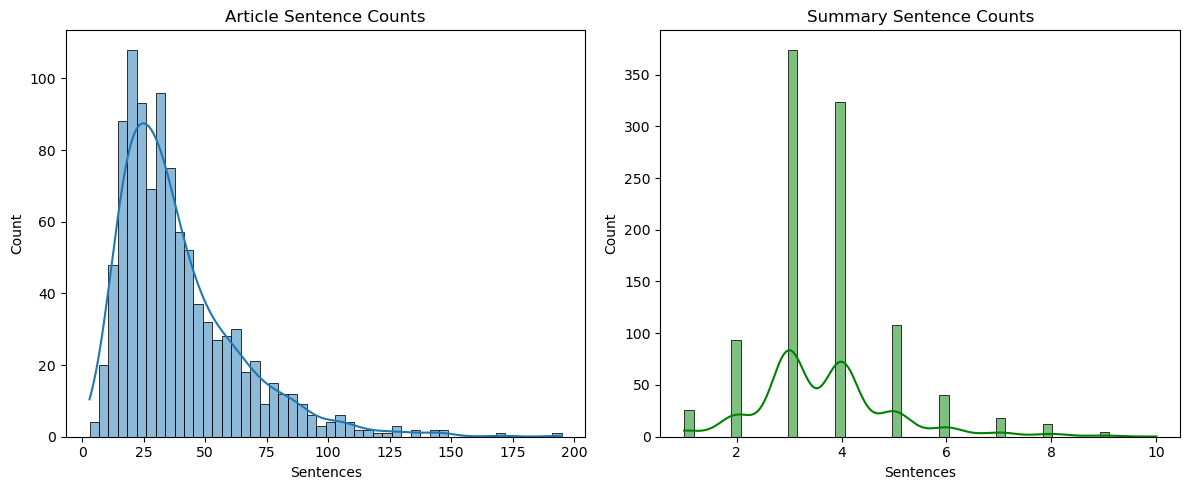

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(article_sent_counts, bins=50, kde=True)
plt.title("Article Sentence Counts")
plt.xlabel("Sentences")

plt.subplot(1, 2, 2)
sns.histplot(summary_sent_counts, bins=50, kde=True, color="green")
plt.title("Summary Sentence Counts")
plt.xlabel("Sentences")

plt.tight_layout()
plt.show()

**Printing two example pairs of articles (first 500 characters) and their corresponding summaries to give a qualitative look at the dataset content.**

In [15]:
print("\nShowing two exploration samples...")

for i in range(1, 3):
    sample = dataset['train'][i]
    print(f"\n--- Sample {i} ---")
    print("Article (first 500 chars):")
    print(sample["article"][:500])
    print("\nSummary:")
    print(sample["highlights"])


Showing two exploration samples...

--- Sample 1 ---
Article (first 500 chars):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary:
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

--- Sample 2 ---
Article (first 500 chars):
MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when i

**Saving the preprocessed train, validation, and test splits to disk in Hugging Face’s dataset format for efficient reuse in training.**

In [17]:
train_dataset.save_to_disk("../data/train")
val_dataset.save_to_disk("../data/val")
test_dataset.save_to_disk("../data/test")
print("Datasets saved to ../data/")

Saving the dataset (0/1 shards):   0%|          | 0/7000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Datasets saved to ../data/
